In [1]:
!pip install timm albumentations scikit-learn opencv-python gradio kaggle --quiet

import os
import random
import numpy as np
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, confusion_matrix
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import torch
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU"
print(f"✅ GPU Available: {torch.cuda.is_available()} — {device_name}")

✅ GPU Available: True — Tesla T4


In [3]:
import shutil
import os

# Create the .kaggle directory if it doesn't exist
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json to the correct location
shutil.move("/content/kaggle.json", "/root/.kaggle/kaggle.json")

# Set correct permissions
!chmod 600 /root/.kaggle/kaggle.json

print("✅ Kaggle API key set up successfully")


✅ Kaggle API key set up successfully


In [4]:
!kaggle datasets download -d ayuraj/asl-dataset -p ./asl_dataset
!unzip -q ./asl_dataset/asl-dataset.zip -d ./asl_dataset
print("✅ Dataset downloaded & extracted successfully")


Dataset URL: https://www.kaggle.com/datasets/ayuraj/asl-dataset
License(s): CC0-1.0
  0% 0.00/56.9M [00:00<?, ?B/s]
100% 56.9M/56.9M [00:00<00:00, 1.42GB/s]
✅ Dataset downloaded & extracted successfully


# Basic Analysis

In [7]:
import re
root_dir = "/content/asl_dataset/asl_dataset"
data_records = []

pattern = re.compile(r"(hand\d+)_(\w+)_(bot|top|left|right|dif)_seg_\d+_cropped\.jpeg", re.IGNORECASE)

for class_label in sorted(os.listdir(root_dir)):
    class_path = os.path.join(root_dir, class_label)
    if not os.path.isdir(class_path):
        continue
    for file in os.listdir(class_path):
        match = pattern.match(file)
        if match:
            hand, char, angle = match.groups()
            data_records.append({
                "class": class_label,
                "hand": hand,
                "angle": angle,
                "file_path": os.path.join(class_path, file)
            })

df = pd.DataFrame(data_records)

In [8]:
df.head()

,class,hand,angle,file_path
0,0,hand5,bot,/content/asl_dataset/asl_dataset/0/hand5_0_bot...
1,0,hand2,bot,/content/asl_dataset/asl_dataset/0/hand2_0_bot...
2,0,hand1,top,/content/asl_dataset/asl_dataset/0/hand1_0_top...
3,0,hand2,right,/content/asl_dataset/asl_dataset/0/hand2_0_rig...
4,0,hand3,dif,/content/asl_dataset/asl_dataset/0/hand3_0_dif...


In [9]:
print("Total images:", len(df))

Total images: 2515


In [10]:
print("Unique classes:", df['class'].nunique())

Unique classes: 36


# Count of each class 0-9 & a-z


In [11]:
print("\nCounts per class:")
print(df['class'].value_counts())


Counts per class:
class
0    70
1    70
2    70
3    70
4    70
5    70
6    70
7    70
8    70
9    70
a    70
b    70
c    70
d    70
e    70
f    70
g    70
h    70
i    70
j    70
k    70
l    70
m    70
n    70
o    70
p    70
q    70
r    70
s    70
u    70
v    70
w    70
y    70
x    70
z    70
t    65
Name: count, dtype: int64


# Count of Class VS Hand

In [12]:
print("\nCounts per (class, hand):")
df.groupby(['class', 'hand']).size().reset_index()


Counts per (class, hand):


,class,hand,0
0,0,hand1,25
1,0,hand2,25
2,0,hand3,5
3,0,hand4,5
4,0,hand5,10
...,...,...,...
175,z,hand1,25
176,z,hand2,25
177,z,hand3,5
178,z,hand4,5


# Count of Class VS Angle

In [13]:
print("\nCounts per (class, angle):")
df.groupby(['class', 'angle']).size().reset_index()


Counts per (class, angle):


,class,angle,0
0,0,bot,20
1,0,dif,20
2,0,left,10
3,0,right,10
4,0,top,10
...,...,...,...
175,z,bot,20
176,z,dif,20
177,z,left,10
178,z,right,10


# Count of Class VS Hand VS Angle

In [14]:
print("\nCounts per (class, hand, angle):")
df.groupby(['class', 'hand', 'angle']).size().reset_index()


Counts per (class, hand, angle):


,class,hand,angle,0
0,0,hand1,bot,5
1,0,hand1,dif,5
2,0,hand1,left,5
3,0,hand1,right,5
4,0,hand1,top,5
...,...,...,...,...
498,z,hand2,top,5
499,z,hand3,dif,5
500,z,hand4,bot,5
501,z,hand5,bot,5


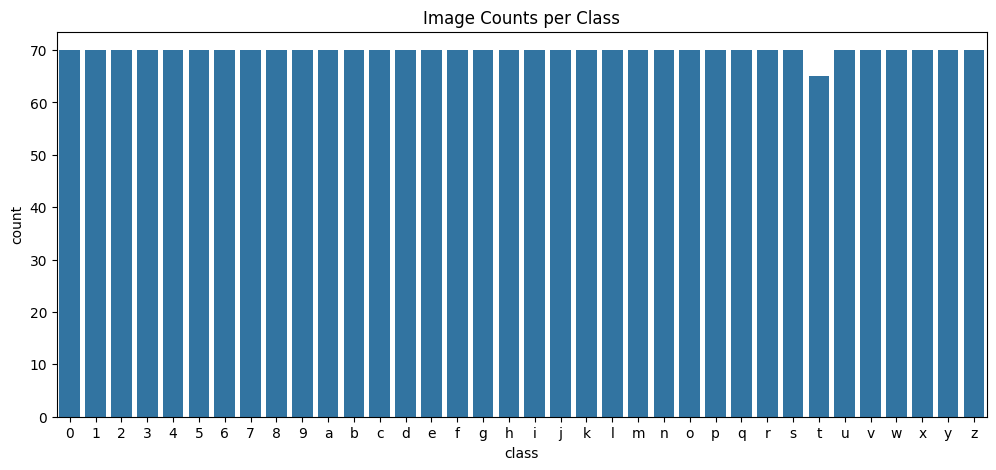

In [15]:
import seaborn as sns
plt.figure(figsize=(12,5))
sns.countplot(x='class', data=df, order=sorted(df['class'].unique()))
plt.title("Image Counts per Class")
plt.show()

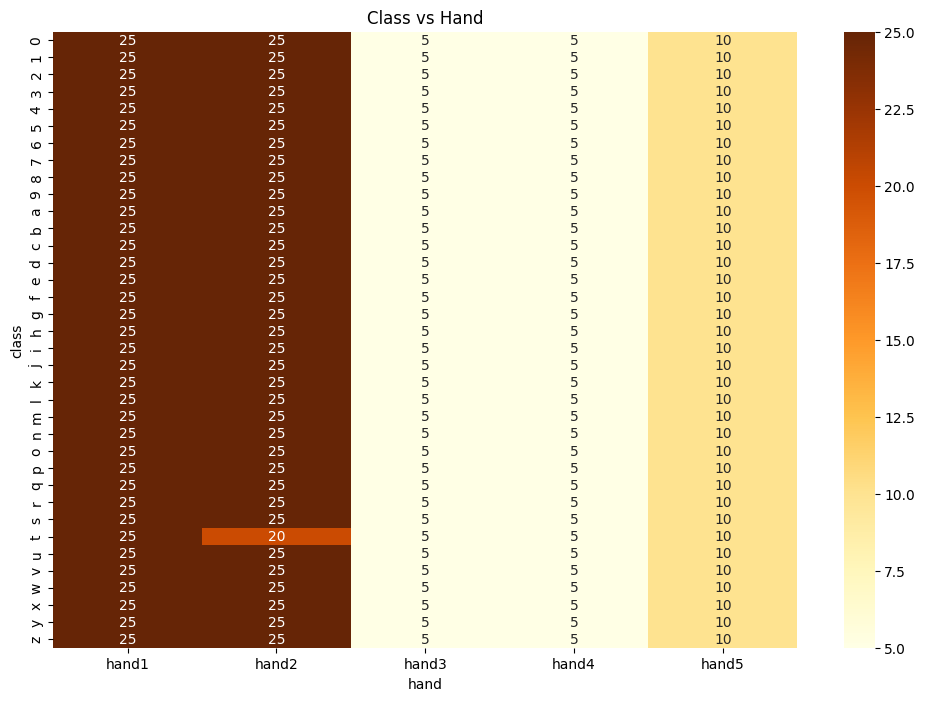

In [16]:
plt.figure(figsize=(12,8))
pivot_hand = df.groupby(['class', 'hand']).size().unstack(fill_value=0)
sns.heatmap(pivot_hand, annot=True, fmt='d', cmap="YlOrBr")
plt.title("Class vs Hand")
plt.show()

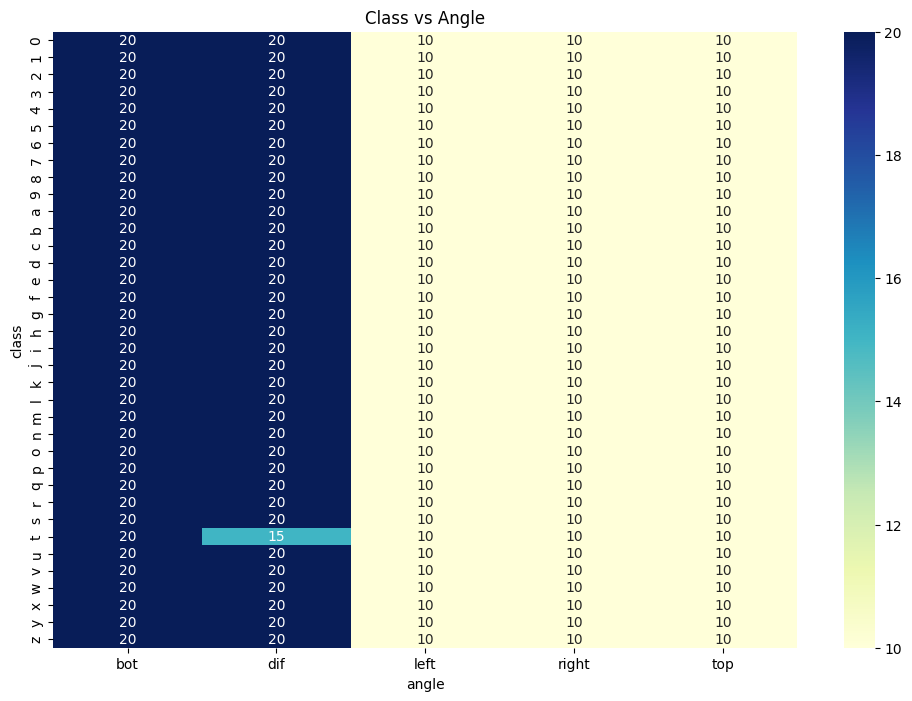

In [17]:

plt.figure(figsize=(12,8))
pivot_angle = df.groupby(['class', 'angle']).size().unstack(fill_value=0)
sns.heatmap(pivot_angle, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Class vs Angle")
plt.show()

/tmp/ipython-input-1543347804.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = df.groupby(['class', 'hand', 'angle']).apply(lambda x: x.sample(min(2, len(x)), random_state=42)).reset_index(drop=True)


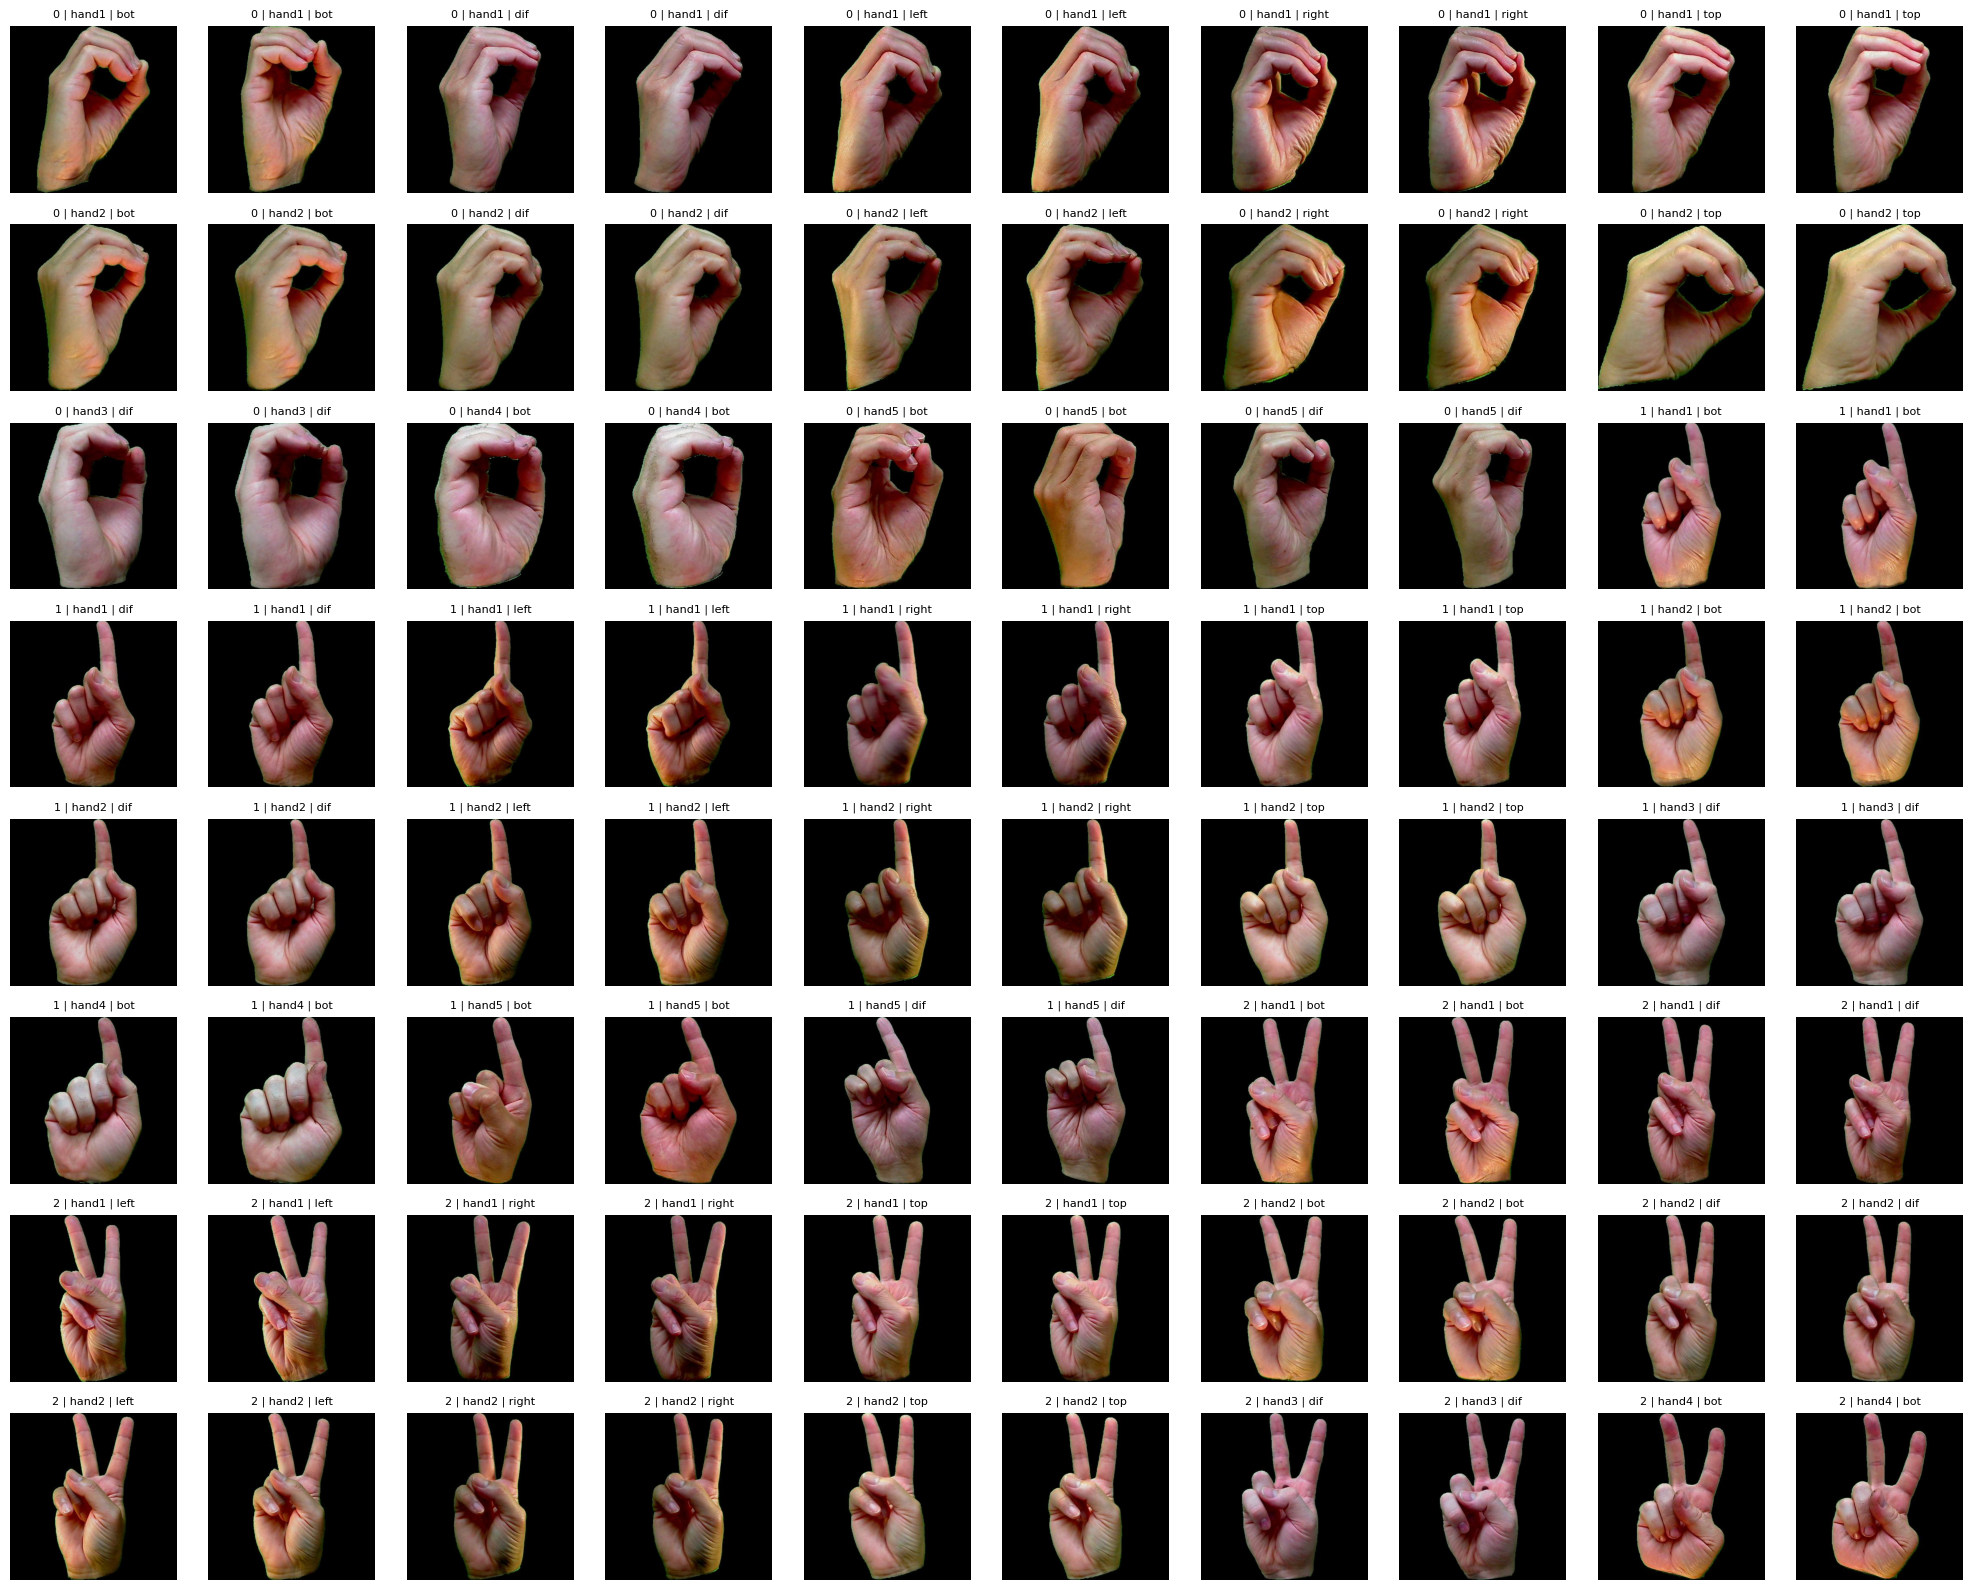

In [18]:
from PIL import Image
sample_df = df.groupby(['class', 'hand', 'angle']).apply(lambda x: x.sample(min(2, len(x)), random_state=42)).reset_index(drop=True)

fig, axes = plt.subplots(8, 10, figsize=(20,16))
axes = axes.flatten()

for i, (_, row) in enumerate(sample_df.iterrows()):
    if i >= len(axes):
        break
    img = Image.open(row['file_path'])
    axes[i].imshow(img)
    axes[i].set_title(f"{row['class']} | {row['hand']} | {row['angle']}", fontsize=8)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Count of Hand VS Angle

angle  bot  dif  left  right  top
hand                             
hand1  180  180   180    180  180
hand2  180  175   180    180  180
hand3    0  180     0      0    0
hand4  180    0     0      0    0
hand5  180  180     0      0    0


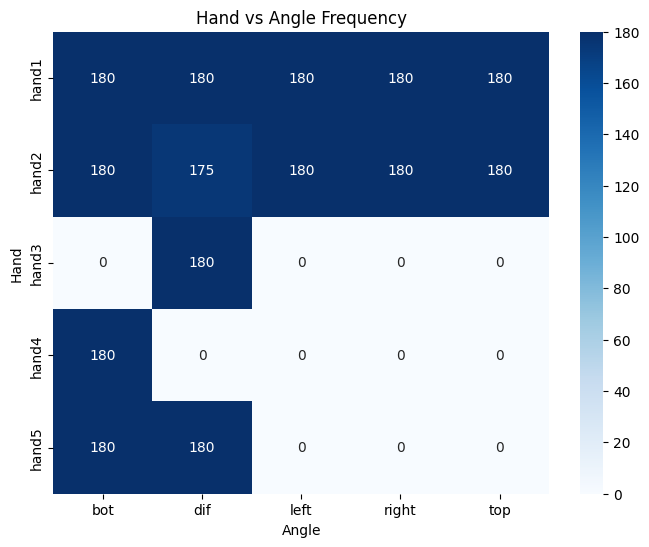

In [19]:
# Count per (hand, angle) combination
hand_angle_counts = df.groupby(['hand', 'angle']).size().unstack(fill_value=0)

print(hand_angle_counts)

# Visualize
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(hand_angle_counts, annot=True, fmt='d', cmap='Blues')
plt.title('Hand vs Angle Frequency')
plt.xlabel('Angle')
plt.ylabel('Hand')
plt.show()


# Percentage of Hand coverage of angles & Missing Hand and Angle combinations

In [20]:
import pandas as pd

# Count occurrences per hand-angle
hand_angle_counts = df.groupby(["hand", "angle"]).size().unstack(fill_value=0)

# Define coverage score (present = 1, missing = 0)
coverage_binary = (hand_angle_counts > 0).astype(int)

# Calculate coverage percentage
coverage_score = coverage_binary.mean(axis=1) * 100

# Find missing combinations
missing_combos = [
    (hand, angle)
    for hand in hand_angle_counts.index
    for angle in hand_angle_counts.columns
    if hand_angle_counts.loc[hand, angle] == 0
]

# Display results
print("=== Coverage Score (%) per Hand ===")
print(coverage_score)
print("\n=== Missing (Hand, Angle) Combinations ===")
for combo in missing_combos:
    print(combo)


=== Coverage Score (%) per Hand ===
hand
hand1    100.0
hand2    100.0
hand3     20.0
hand4     20.0
hand5     40.0
dtype: float64

=== Missing (Hand, Angle) Combinations ===
('hand3', 'bot')
('hand3', 'left')
('hand3', 'right')
('hand3', 'top')
('hand4', 'dif')
('hand4', 'left')
('hand4', 'right')
('hand4', 'top')
('hand5', 'left')
('hand5', 'right')
('hand5', 'top')


# Feature Engineering and EDA

In [5]:
import os
import re
import pandas as pd

root_dir = "/content/asl_dataset/asl_dataset"
data_records = []

# Regex now also captures "seg_x"
pattern = re.compile(
    r"(hand\d+)_(\w+)_(bot|top|left|right|dif)_seg_(\d+)_cropped\.jpeg",
    re.IGNORECASE
)

for class_label in sorted(os.listdir(root_dir)):
    class_path = os.path.join(root_dir, class_label)
    if not os.path.isdir(class_path):
        continue

    for file in os.listdir(class_path):
        match = pattern.match(file)
        if match:
            hand, char, angle, seg = match.groups()

            data_records.append({
                "id": len(data_records),  # unique ID for tracking
                "class": class_label.upper().strip(),  # normalized
                "char": char.upper().strip(),          # extracted char for double-check
                "hand": hand.lower().strip(),          # standardized
                "angle": angle.lower().strip(),
                "seg": int(seg),
                "file_name": file,
                "file_path": os.path.join(class_path, file)
            })

# Create dataframe
df = pd.DataFrame(data_records)

# Optional: sanity checks
print("Total images:", len(df))
print("Classes:", df["class"].nunique())
print("Hands:", df["hand"].unique())
print("Angles:", df["angle"].unique())
print("Example rows:")
print(df.sample(5))


Total images: 2515
Classes: 36
Hands: ['hand5' 'hand2' 'hand1' 'hand3' 'hand4']
Angles: ['bot' 'top' 'right' 'dif' 'left']
Example rows:
        id class char   hand angle  seg                       file_name  \
437    437     6    6  hand2   top    3  hand2_6_top_seg_3_cropped.jpeg   
335    335     4    4  hand3   dif    1  hand3_4_dif_seg_1_cropped.jpeg   
738    738     A    A  hand1   dif    5  hand1_a_dif_seg_5_cropped.jpeg   
1196  1196     H    H  hand1   top    2  hand1_h_top_seg_2_cropped.jpeg   
595    595     8    8  hand2   dif    1  hand2_8_dif_seg_1_cropped.jpeg   

                                              file_path  
437   /content/asl_dataset/asl_dataset/6/hand2_6_top...  
335   /content/asl_dataset/asl_dataset/4/hand3_4_dif...  
738   /content/asl_dataset/asl_dataset/a/hand1_a_dif...  
1196  /content/asl_dataset/asl_dataset/h/hand1_h_top...  
595   /content/asl_dataset/asl_dataset/8/hand2_8_dif...  


In [6]:
# Check if any class-hand-angle is missing
df.groupby(["class", "hand", "angle"])["id"].count().unstack(fill_value=0)


angle        bot  dif  left  right  top
class hand                             
0     hand1    5    5     5      5    5
      hand2    5    5     5      5    5
      hand3    0    5     0      0    0
      hand4    5    0     0      0    0
      hand5    5    5     0      0    0
...          ...  ...   ...    ...  ...
Z     hand1    5    5     5      5    5
      hand2    5    5     5      5    5
      hand3    0    5     0      0    0
      hand4    5    0     0      0    0
      hand5    5    5     0      0    0

[180 rows x 5 columns]

In [7]:
# Check angle coverage per class
df.groupby(["class", "angle"])["id"].count().unstack(fill_value=0)


angle,bot,dif,left,right,top
class,,,,,
0,20,20,10,10,10
1,20,20,10,10,10
2,20,20,10,10,10
3,20,20,10,10,10
4,20,20,10,10,10
5,20,20,10,10,10
6,20,20,10,10,10
7,20,20,10,10,10
8,20,20,10,10,10


In [24]:
# Check duplicates by (class, hand, angle)
df.groupby(["class", "hand", "angle"])["seg"].nunique()


class  hand   angle
0      hand1  bot      5
              dif      5
              left     5
              right    5
              top      5
                      ..
Z      hand2  top      5
       hand3  dif      5
       hand4  bot      5
       hand5  bot      5
              dif      5
Name: seg, Length: 503, dtype: int64

In [25]:
# Count unique segments for each class-hand-angle
seg_counts = df.groupby(["class", "hand", "angle"])["seg"].nunique().reset_index()

# Flag issues
bad = seg_counts[seg_counts["seg"] != 5]

if bad.empty:
    print("✅ All class-hand-angle groups have exactly 5 segments")
else:
    print("❌ Issues found:")
    display(bad)


✅ All class-hand-angle groups have exactly 5 segments


In [26]:
# Count unique segments for each class-hand-angle
seg_counts = df.groupby(["class", "hand", "angle"])["seg"].nunique().reset_index()

# Flag issues
bad = seg_counts[seg_counts["seg"] != 5]

if bad.empty:
    print("✅ All class-hand-angle groups have exactly 5 segments")
else:
    print("❌ Issues found:")
    display(bad)

✅ All class-hand-angle groups have exactly 5 segments


In [27]:
import os

# Check all filepaths exist
missing_files = [fp for fp in df["file_path"] if not os.path.exists(fp)]

if missing_files:
    print(f"❌ Missing {len(missing_files)} files")
else:
    print("✅ All files exist on disk")


✅ All files exist on disk


In [9]:
import hashlib

# Hash each image to detect duplicates
def file_hash(path):
    with open(path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

df["hash"] = df["file_path"].apply(file_hash)

# Find duplicates
dupes = df[df.duplicated("hash", keep=False)].sort_values("hash")

if not dupes.empty:
    print("⚠️ Found some exact duplicate files")
    display(dupes.head(20))
else:
    print("✅ No exact duplicate images found")


✅ No exact duplicate images found


In [29]:
summary = (
    df.groupby(["class", "hand", "angle"])
    .size()
    .unstack(fill_value=0)
)

summary


angle        bot  dif  left  right  top
class hand                             
0     hand1    5    5     5      5    5
      hand2    5    5     5      5    5
      hand3    0    5     0      0    0
      hand4    5    0     0      0    0
      hand5    5    5     0      0    0
...          ...  ...   ...    ...  ...
Z     hand1    5    5     5      5    5
      hand2    5    5     5      5    5
      hand3    0    5     0      0    0
      hand4    5    0     0      0    0
      hand5    5    5     0      0    0

[180 rows x 5 columns]

In [11]:
df

,id,class,char,hand,angle,seg,file_name,file_path,hash
0,0,0,0,hand5,bot,4,hand5_0_bot_seg_4_cropped.jpeg,/content/asl_dataset/asl_dataset/0/hand5_0_bot...,b08ec5e93a41fae05b001b4c1a816b12
1,1,0,0,hand2,bot,3,hand2_0_bot_seg_3_cropped.jpeg,/content/asl_dataset/asl_dataset/0/hand2_0_bot...,75a8b76ed83347c4ba69cb601a819edc
2,2,0,0,hand1,top,2,hand1_0_top_seg_2_cropped.jpeg,/content/asl_dataset/asl_dataset/0/hand1_0_top...,32b22030703a0e678129cd2f29008b2a
3,3,0,0,hand2,right,4,hand2_0_right_seg_4_cropped.jpeg,/content/asl_dataset/asl_dataset/0/hand2_0_rig...,43b6a4feb083a90c622eaa76565b5af1
4,4,0,0,hand3,dif,2,hand3_0_dif_seg_2_cropped.jpeg,/content/asl_dataset/asl_dataset/0/hand3_0_dif...,cf30efbbccf1875b4b0728c4c1062fa1
...,...,...,...,...,...,...,...,...,...
2510,2510,Z,Z,hand4,bot,1,hand4_z_bot_seg_1_cropped.jpeg,/content/asl_dataset/asl_dataset/z/hand4_z_bot...,3ad3de7c33dea931f454ae924d1b50c1
2511,2511,Z,Z,hand2,left,2,hand2_z_left_seg_2_cropped.jpeg,/content/asl_dataset/asl_dataset/z/hand2_z_lef...,1c6d791d261c90e3a549548092af02d3
2512,2512,Z,Z,hand5,dif,3,hand5_z_dif_seg_3_cropped.jpeg,/content/asl_dataset/asl_dataset/z/hand5_z_dif...,ea0f68d4d52aa22dd73c1e29577e38e2
2513,2513,Z,Z,hand2,bot,3,hand2_z_bot_seg_3_cropped.jpeg,/content/asl_dataset/asl_dataset/z/hand2_z_bot...,c4e9304b7477c94e2a9f529c4547926a


# Image based processing

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import os

# Use file paths from df
image_paths = df["file_path"].tolist()

### 1. Dimension Consistency
dims = []
for path in image_paths[:1000]:  # sample subset to speed up
    with Image.open(path) as img:
        dims.append(img.size)  # (width, height)

print("Unique dimensions:", Counter(dims))

Unique dimensions: Counter({(400, 400): 1000})


In [13]:
### 2. Color Channels Consistency
modes = []
for path in image_paths[:1000]:
    with Image.open(path) as img:
        modes.append(img.mode)

print("Color modes distribution:", Counter(modes))



Color modes distribution: Counter({'RGB': 1000})


In [17]:
### 3. Pixel Intensity Range (check sample image)
sample_img = cv2.imread(image_paths[0])
print("Pixel range (sample):", sample_img.min(), sample_img.max())


Pixel range (sample): 0 255


In [16]:
### 4. Mean/Std per Channel (sample 500)
means, stds = [], []
for path in image_paths[:500]:
    img = cv2.imread(path) / 255.0
    means.append(img.mean(axis=(0,1)))  # (B, G, R)
    stds.append(img.std(axis=(0,1)))

means = np.mean(means, axis=0)
stds = np.mean(stds, axis=0)
print("Mean (BGR):", means)
print("Std (BGR):", stds)

Mean (BGR): [0.13487636 0.14811856 0.21195796]
Std (BGR): [0.20601831 0.21629084 0.29923914]


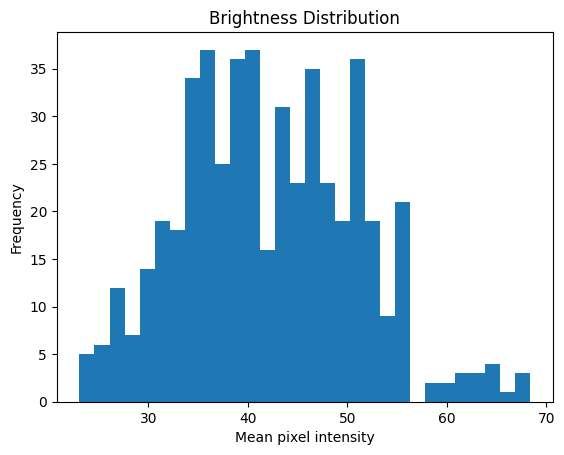

In [18]:
### 5. Brightness Distribution
brightness = []
for path in image_paths[:500]:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    brightness.append(img.mean())

plt.hist(brightness, bins=30)
plt.title("Brightness Distribution")
plt.xlabel("Mean pixel intensity")
plt.ylabel("Frequency")
plt.show()

In [14]:
### 6. Corrupt Image Check
bad_files = []
for path in image_paths:
    try:
        Image.open(path).verify()
    except:
        bad_files.append(path)

print("Corrupt files found:", len(bad_files))
if bad_files:
    print(bad_files[:10])  # preview

Corrupt files found: 0


In [19]:
import numpy as np
import scipy.stats as stats

brightness = np.array(brightness)

# Basic stats
mean_b = np.mean(brightness)
median_b = np.median(brightness)
std_b = np.std(brightness)
min_b, max_b = np.min(brightness), np.max(brightness)

# Shape stats
skew_b = stats.skew(brightness)
kurt_b = stats.kurtosis(brightness)

print("Brightness Stats:")
print(f" Mean:   {mean_b:.2f}")
print(f" Median: {median_b:.2f}")
print(f" Std:    {std_b:.2f}")
print(f" Range:  {min_b:.2f} – {max_b:.2f}")
print(f" Skew:   {skew_b:.2f}")
print(f" Kurtosis: {kurt_b:.2f}")


Brightness Stats:
 Mean:   42.19
 Median: 41.25
 Std:    8.79
 Range:  23.09 – 68.40
 Skew:   0.27
 Kurtosis: -0.25


In [20]:
import cv2
import numpy as np

# Function to compute mean brightness of an image
def get_brightness(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)

# Compute brightness per image
df["brightness"] = df["file_path"].apply(get_brightness)

# Aggregate brightness per class
class_brightness_stats = df.groupby("class")["brightness"].agg(
    ["mean", "median", "std", "min", "max"]
).reset_index()

# Sort by mean brightness for clarity
class_brightness_stats = class_brightness_stats.sort_values("mean")

print(class_brightness_stats)


   class       mean     median        std        min        max
25     P  30.331157  29.557197   5.278588  22.992956  42.237056
27     R  30.418977  30.619106   3.963809  21.379856  38.883444
17     H  31.157205  31.833900   3.713151  23.469044  38.379631
1      1  33.395422  33.926462   6.025036  23.162725  47.463975
30     U  33.455622  33.139409   4.193086  23.028688  40.328006
35     Z  33.610088  33.134269   5.669691  24.104694  46.586062
31     V  34.061061  33.691725   5.614575  23.702206  43.880481
2      2  34.570843  34.408066   4.487019  27.303475  44.560237
16     G  35.321179  35.334719   5.659422  27.397981  52.285856
13     D  36.315806  36.027166   3.682042  30.753550  44.074975
20     K  36.487035  34.403822   5.554941  28.357450  50.950800
32     W  37.413683  36.688494   5.137648  28.029837  49.841075
6      6  38.657107  37.932347   6.058652  30.226644  53.221844
7      7  40.053601  40.876066   5.603396  30.581056  51.571250
21     L  40.218702  40.160888   5.25030